In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import sympy
sympy.init_printing()
import emcee
import corner

In [78]:
data1 = np.loadtxt('proj1data1.txt')

data2 = np.loadtxt('proj1data2.txt')

data3 = np.loadtxt('proj1data3.txt')

data1x = data1[:,0] - 2450000
data2x = data2[:,0] - 2450000
data3x = data3[:,0] - 2450000

data1y = (data1[:,1])
data2y = (data2[:,1])
data3y = (data3[:,1]) 

data1err = data1[:,2]
data2err = data2[:,2]
data3err = data3[:,2]



## Defining the Model and Chisq


In [11]:
def model(par,dat):
    u_0 = par[0]
    t_0 = par[1]
    t_E = par[2]
    m_src = par[3]
    fbl = par[4]
    model = []
    for i in range(len(dat)):
        u = np.sqrt(u_0**2 + (((dat[i,0]-t_0)**2)/t_E**2))
        A = (u**2 + 2.0)/(u* np.sqrt(u**2 + 4.0))
        Abl = (fbl*A) + (1-fbl)
        mag = (m_src - 2.5*np.log10(Abl))
        model.append(mag)
    return(model)


def chisq(par,dat):
    chisq = 0
    mod=model(par,dat)
    if par[2] <= 0:
        chisq = 10000000000000000000000
        return(chisq)
    if par[4] < 0:
        chisq = 10000000000000000000000
        return(chisq)
    if par[4] > 1:
        chisq = 10000000000000000000000
        return(chisq)
    for i in range(len(dat)):
        chisq = chisq + (((mod[i] - dat[i,1])**2)/dat[i,2]**2) 
    #print(par,chisq)
    return(chisq)


def lnprob(par,dat):
    return -0.5*chisq(par,dat)






# Dataset 1



## Plotting the observed values


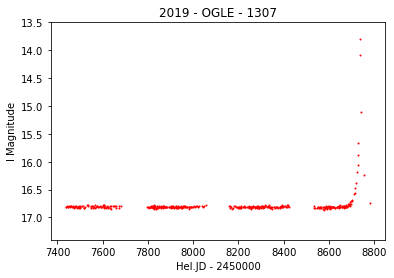

In [12]:
fig,ax = plt.subplots(1)
ax.plot(data1x,data1y, "ro", markersize = 1)
ax.invert_yaxis()
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('Model 1: 2019 - OGLE - 1307')
plt.ylim(17.4,13.5)
#plt.errorbar(data1x,data1y,data1err, fmt=".",color='black')



## Running an optimize function for our predictions


In [13]:

# got the predicted values off the website 

opt=optimize.fmin(chisq,[0.047,2458738.369,23.117,16.811,0.885],args = (data1,))
print(opt)



Optimization terminated successfully.
         Current function value: 989.209876
         Iterations: 213
         Function evaluations: 406
[4.67011879e-02 2.45873837e+06 2.31673700e+01 1.68109991e+01
 8.83665847e-01]



## Running the mcmc analysis


In [14]:
ndim = 5
nwalk = 20
nburn = 500
nmain = 1000


plab = ['u_0','t_0','t_E','m_src','fbl']
p0 = np.array([0.0468202686,2458738.37,23.1619667,16.8110030,0.883975482])
pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])
sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob, args=(data1,)) 
print('burn-in run')
pos,prob,state = sampler.run_mcmc(pstart,nburn)
print('main run')
sampler.reset()
res = sampler.run_mcmc(pos,nmain)
samples = sampler.get_chain(flat=True)

burn-in run
main run



## Defining the mcmc plot


In [15]:
def mcmcplot(sampler):
 # plot the walkers
     labels = [r'$t{peak}$',r'$f_{bl}$',r'$f0$', r'$u{min}$', r'$\tau$']
     f,ax = plt.subplots(ndim,1,figsize=(10,10))
     for idim in range(ndim):
         for iwalk in range(nwalk):
             ax[idim].plot(sampler.chain[iwalk,:,idim])
         ax[idim].set_xlabel('step')
         ax[idim].set_ylabel(labels[idim])
     f.tight_layout()
     f.show()


## Plotting the range of predictions from the analysis


<ipython-input-16-e0f3bb5f4ff2>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


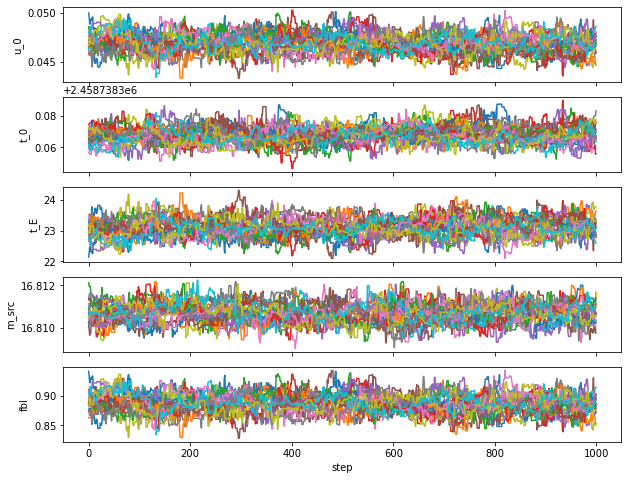

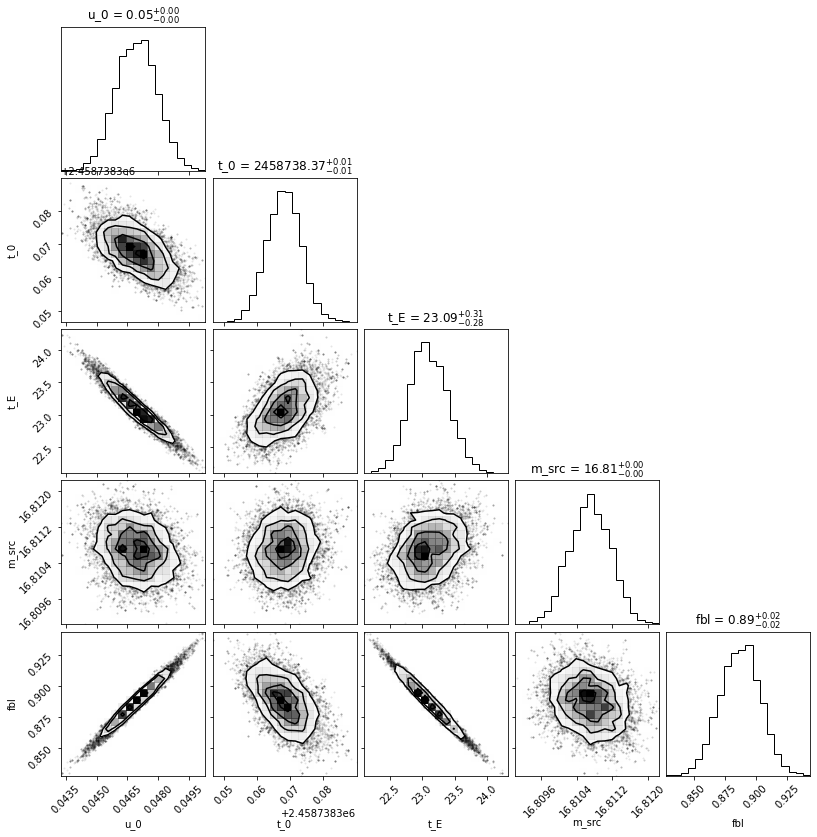

In [16]:
f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_ylabel(plab[idim])
ax[-1].set_xlabel('step')
f.show()
f=corner.corner(samples,show_titles=True, labels=plab)


## Residuals Plot


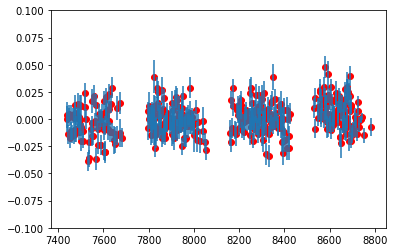

In [19]:
residual = (data1y- model([4.67202686e-02, 2.45873837e+06, 2.31619667e+01, 1.68110030e+01, 8.83975482e-01],data1))
plt.scatter(data1x, residual, color = 'r')
plt.errorbar(data1x, residual, yerr = data1err, ls = 'none')
plt.ylim(-0.1, 0.1)


## Finding the average value for each variable within each predicted range


In [17]:


u_01 = np.average(samples[:,0])
t_01 = np.average(samples[:,1])
t_E1 = np.average(samples[:,2])
m_src1 = np.average(samples[:,3])
fbl1 = np.average(samples[:,4])





## Plotting the observed values and the model we created with the predicted values


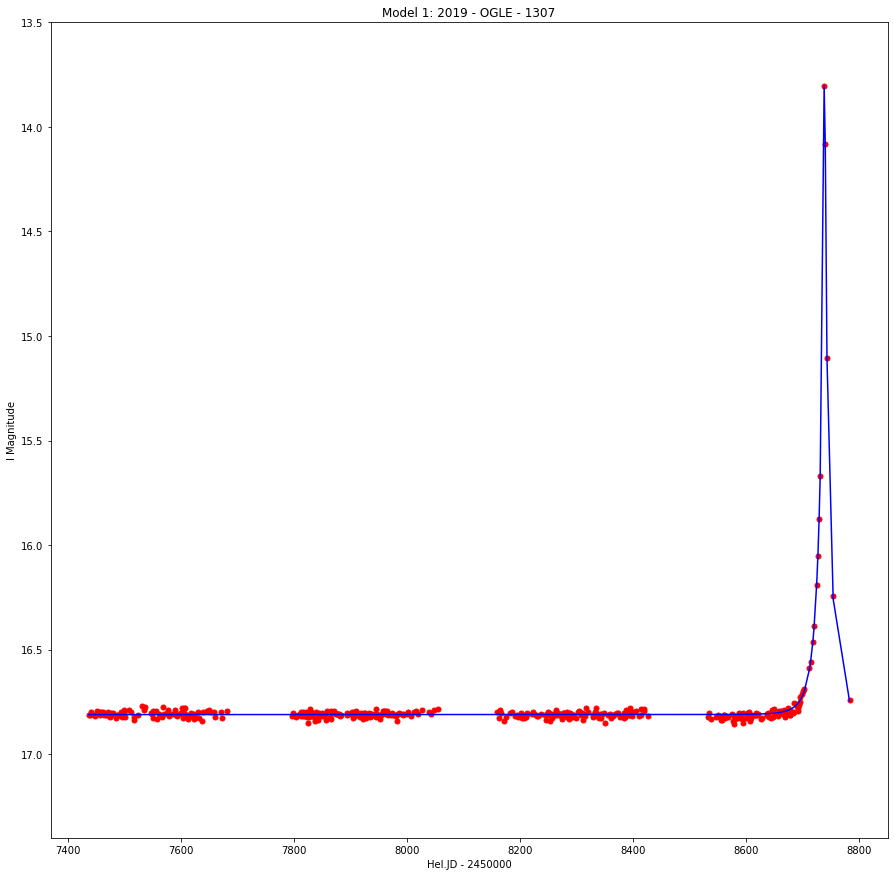

In [18]:


fig,ax = plt.subplots(1,figsize=(15,15))
ax.plot(data1x,data1y, "ro", markersize = 5)
ax.invert_yaxis()
ax.plot(data1x,model([u_01,t_01,t_E1,m_src1,fbl1],data1),color = "blue")
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('Model 1: 2019 - OGLE - 1307')
plt.ylim(17.4,13.5)
#plt.errorbar(data1x,model([u_01,t_01,t_E1,m_src1,fbl1],data1),yerr=data1err,fmt='',color='black')


# Dataset 2



## Plotting the observed values


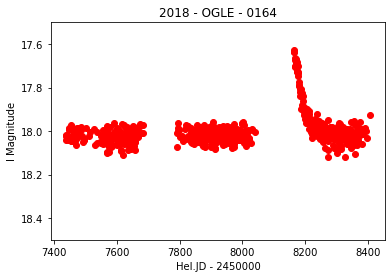

In [4]:
fig,ax = plt.subplots(1)
ax.plot(data2x,data2y,'ro')
ax.invert_yaxis()
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('Model 2: 2018 - OGLE - 0164')
plt.ylim(18.5,17.5)


## Defining the Model and Chisq


In [5]:
def model2(par,dat):
    u_0 = par[0]
    t_0 = par[1]
    t_E = par[2]
    m_src = par[3]
    fbl = par[4]
    model2 = []
    for i in range(len(dat)):
        u = np.sqrt(u_0**2 + (((dat[i,0]-t_0)**2)/t_E**2))
        A = (u**2 + 2.0)/(u* np.sqrt(u**2 + 4.0))
        Abl = (fbl*A) + (1-fbl)
        mag = (m_src - 2.5*np.log10(Abl))
        model2.append(mag)
    return(model2)


def chisq2(par,dat):
    chisq2 = 0
    mod2=model2(par,dat)
    if par[2] <= 0.00:
        chisq2 = 10000000000000000000000
        return(chisq2)
    if par[4] < 0.00:
        chisq2 = 10000000000000000000000
        return(chisq2)
    if par[4] > 1.00:
        chisq2 = 10000000000000000000000
        return(chisq2)
    for i in range(len(dat)):
        chisq2 = chisq2 + (((mod2[i] - dat[i,1])**2)/dat[i,2]**2) 
    #print(par,chisq)
    return(chisq2)


def lnprob2(par,dat):
    return -0.5*chisq2(par,dat)




## Running an optimize function for our predictions


In [7]:

# got the predicted values off the website

opt2=optimize.fmin(chisq2,[0.8,2458159,28,18,1],args = (data2[0:733],))
print(opt2)



Optimization terminated successfully.
         Current function value: 1326.882854
         Iterations: 545
         Function evaluations: 972
[1.00353023e+00 2.45816506e+06 2.49406404e+01 1.80061327e+01
 1.00000000e+00]



## Running the mcmc analysis


In [43]:

ndim = 5
nwalk = 20
nburn = 500
nmain = 1000


plab = ['u_02','t_02','t_E2','m_src2','fbl2']
p0 = np.array([1.0035, 2458165, 24.94, 18.006, 0.95])
pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])
sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob2, args=(data2,)) 
print('burn-in run')
pos,prob,state = sampler.run_mcmc(pstart,nburn)
print('main run')
sampler.reset()
res = sampler.run_mcmc(pos,nmain)
samples = sampler.get_chain(flat=True)


burn-in run
main run


<ipython-input-5-59f3cfedc372>:12: RuntimeWarning: invalid value encountered in log10
  mag = (m_src - 2.5*np.log10(Abl))



## Plotting the range of predictions from the analysis


<ipython-input-46-e0f3bb5f4ff2>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


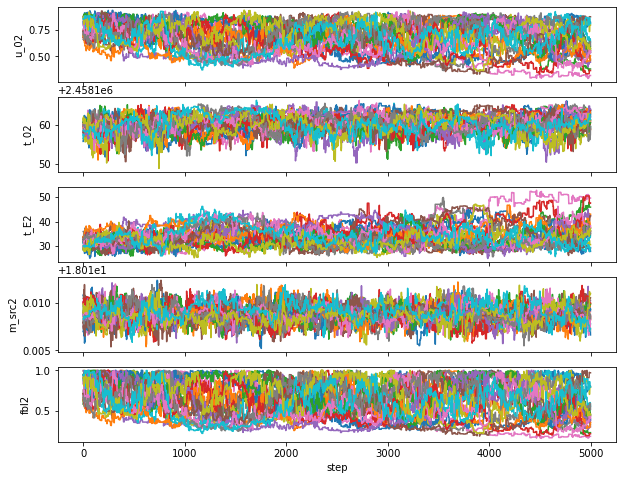

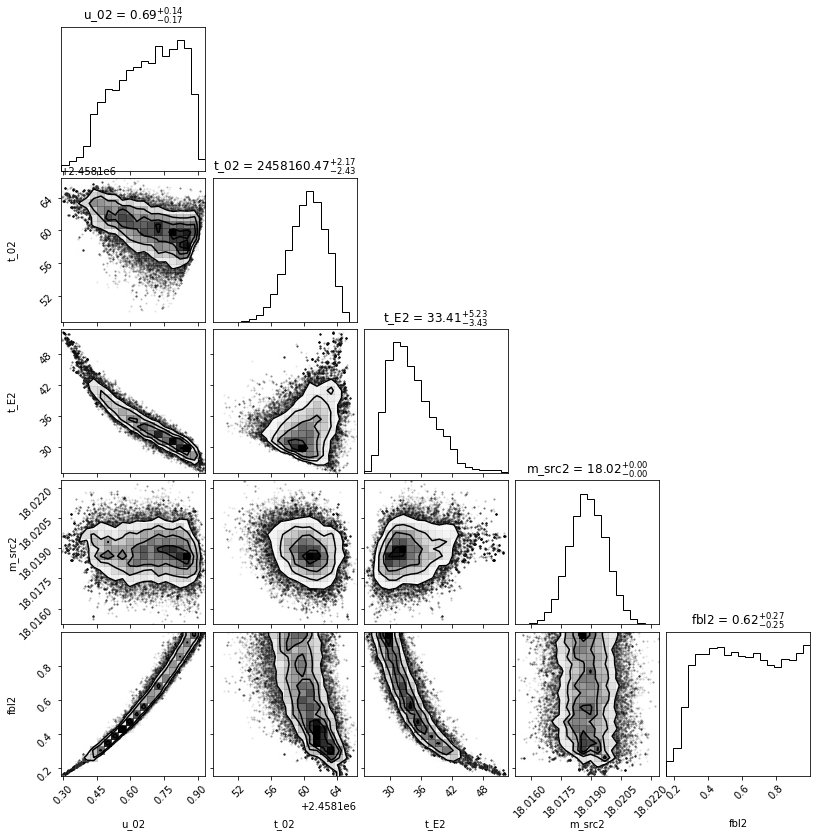

In [46]:

f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_ylabel(plab[idim])
ax[-1].set_xlabel('step')
f.show()
f=corner.corner(samples,show_titles=True, labels=plab)


## Finding the average value for each variable within each predicted range


In [47]:

u_02 = np.average(samples[:,0])
t_02 = np.average(samples[:,1])
t_E2 = np.average(samples[:,2])
m_src2 = np.average(samples[:,3])
fbl2 = np.average(samples[:,4])




## Plotting the observed values and the model we created with the predicted values


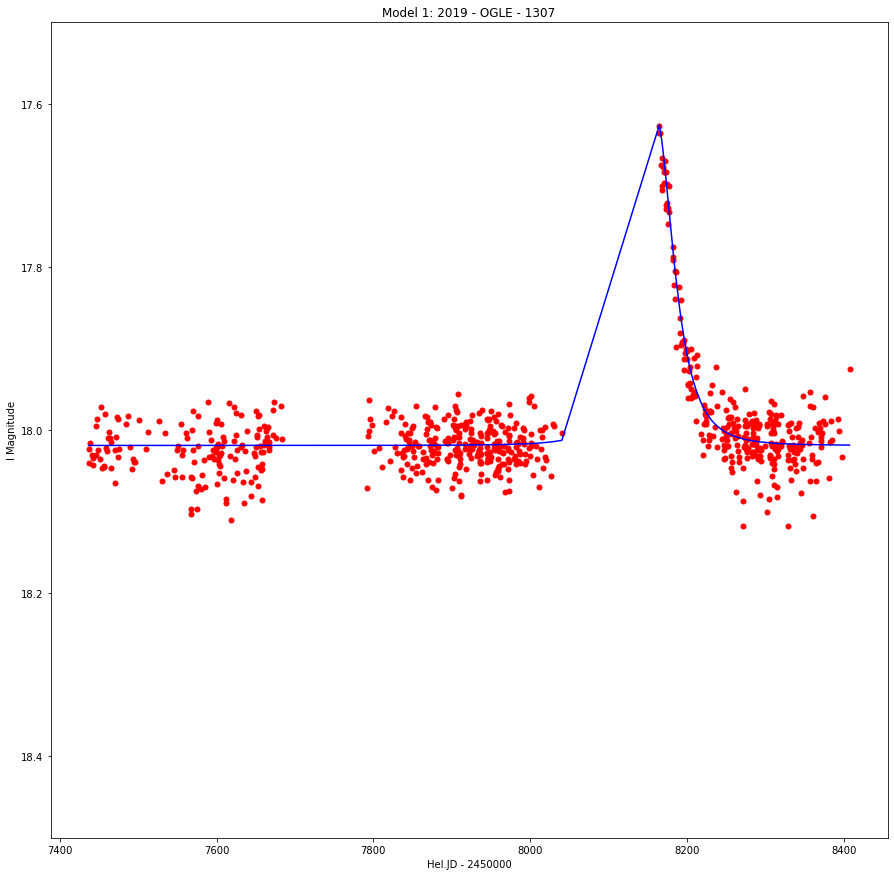

In [53]:
fig,ax = plt.subplots(1,figsize=(15,15))
ax.plot(data2x,data2y, "ro", markersize = 5)
ax.invert_yaxis()
ax.plot(data2x,model2([u_02,t_02,t_E2,m_src2,fbl2],data2),color = "blue")
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('Model 2: 2018 - OGLE - 0164')
plt.ylim(18.5,17.5)
#plt.errorbar(data1x,model([u_01,t_01,t_E1,m_src1,fbl1],data1),yerr=data1err,fmt='',color='black')



## Residuals Plot


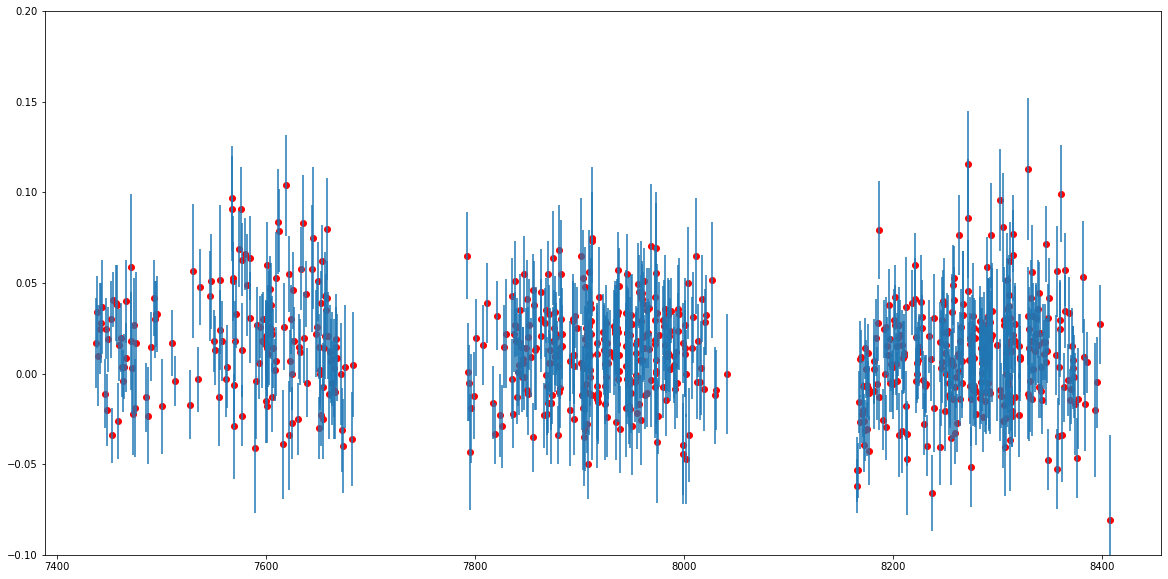

In [62]:
residual = (data2y- model2([1.00353023e+00, 2.45816506e+06, 2.49406404e+01, 1.80061327e+01, 1.00000000e+00],data2))
fig,ax = plt.subplots(1,figsize=(20,10))
plt.scatter(data2x, residual, color = 'r')
plt.errorbar(data2x, residual, yerr = data2err, ls = 'none')
plt.ylim(-0.1, 0.2)


# Dataset 3



## Plotting the Observed datapoints


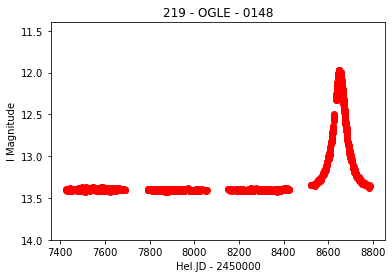

In [63]:
fig,ax = plt.subplots(1)
ax.plot(data3x,data3y,'ro')
ax.invert_yaxis()
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('Model 3: 2019 - OGLE - 0148')
plt.ylim(14,11.4)


## Defining the Model and and Chisq


In [67]:
def model(par,dat):
    u_0 = par[0]
    t_0 = par[1]
    t_E = par[2]
    m_src = par[3]
    fbl = par[4]
    model = []
    for i in range(len(dat)):
        u = np.sqrt(u_0**2 + (((dat[i,0]-t_0)**2)/t_E**2))
        A = (u**2 + 2.0)/(u* np.sqrt(u**2 + 4.0))
        Abl = (fbl*A) + (1-fbl)
        mag = (m_src - 2.5*np.log10(Abl))
        model.append(mag)
    return(model)


def chisq(par,dat):
    chisq = 0
    mod=model(par,dat)
    if par[2] <= 0.00:
        chisq = 10000000000000000000000
        return(chisq)
    if par[4] < 0.00:
        chisq = 10000000000000000000000
        return(chisq)
    if par[4] > 1.00:
        chisq = 10000000000000000000000
        return(chisq)
    for i in range(len(dat)):
        chisq = chisq + (((mod[i] - dat[i,1])**2)/dat[i,2]**2) 
    #print(par,chisq)
    return(chisq)


def lnprob(par,dat):
    return -0.5*chisq(par,dat)



## Running an optimize function for our predictions


In [64]:
len(data3)

In [71]:


# got the predicted values off the website

opt=optimize.fmin(chisq,[0.279,2458651,58.2,13,0.99],args = (data3[0:3690],))
print(opt)



Optimization terminated successfully.
         Current function value: 53431.384777
         Iterations: 308
         Function evaluations: 570
[2.79412051e-01 2.45865120e+06 5.88102302e+01 1.34040365e+01
 9.94931947e-01]



## Running the mcmc analysis


In [72]:

ndim = 5
nwalk = 20
nburn = 500
nmain = 1000


plab = ['u_03','t_03','t_E3','m_src3','fbl3']
p0 = np.array([0.279, 2458651.2, 58.8, 13.4, 0.9])
pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])
sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob2, args=(data3,)) 
print('burn-in run')
pos,prob,state = sampler.run_mcmc(pstart,nburn)
print('main run')
sampler.reset()
res = sampler.run_mcmc(pos,nmain)
samples = sampler.get_chain(flat=True)


burn-in run
main run



## Plotting the range of predictions from the analysis


<ipython-input-73-e0f3bb5f4ff2>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


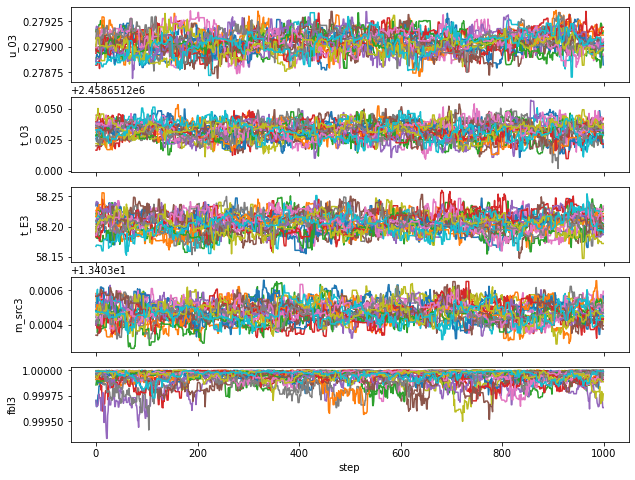

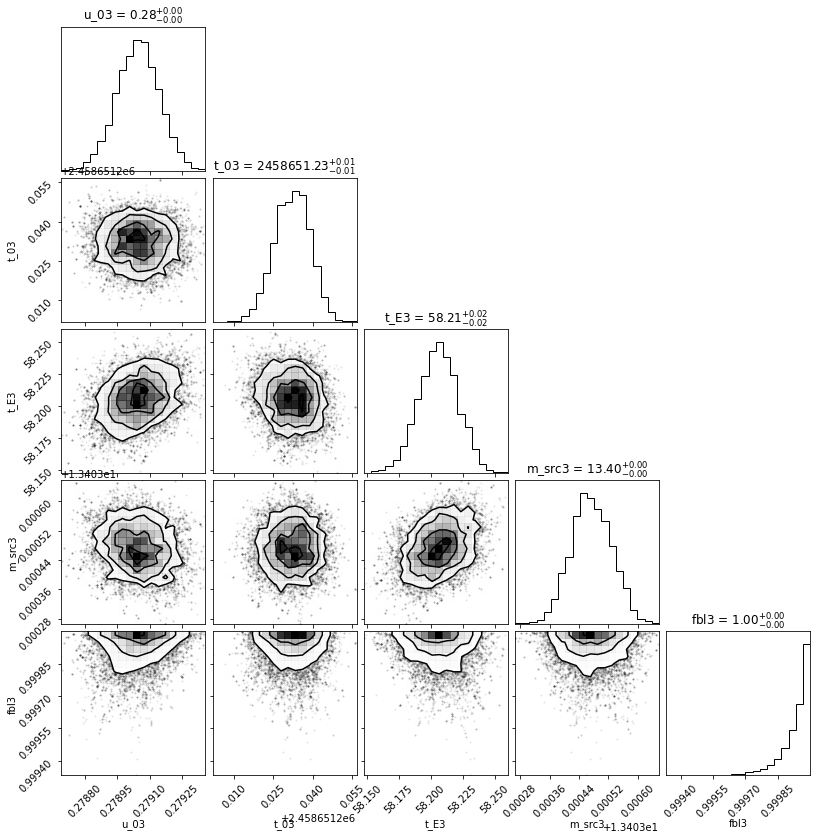

In [73]:


f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_ylabel(plab[idim])
ax[-1].set_xlabel('step')
f.show()
f=corner.corner(samples,show_titles=True, labels=plab)


## Finding the average value for each variable within each predicted range


In [74]:

u_03 = np.average(samples[:,0])
t_03 = np.average(samples[:,1])
t_E3 = np.average(samples[:,2])
m_src3 = np.average(samples[:,3])
fbl3 = np.average(samples[:,4])




## Plotting the observed values and the model we created with the predicted values


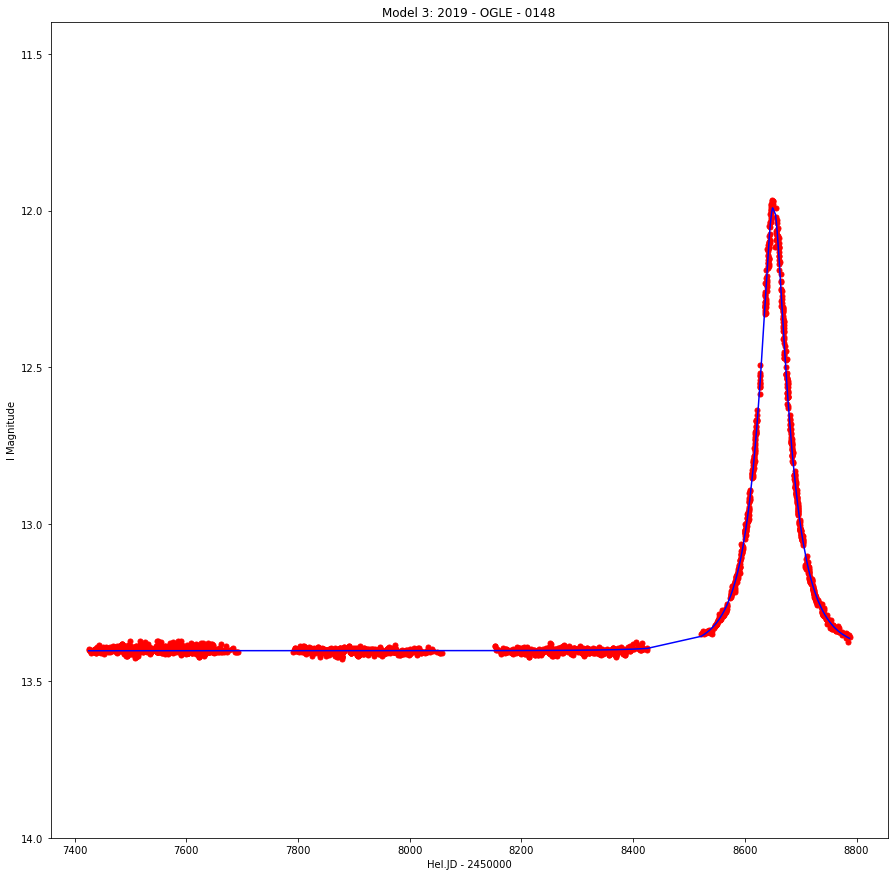

In [75]:

fig,ax = plt.subplots(1,figsize=(15,15))
ax.plot(data3x,data3y, "ro", markersize = 5)
ax.invert_yaxis()
ax.plot(data3x,model([u_03,t_03,t_E3,m_src3,fbl3],data3),color = "blue")
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('Model 3: 2019 - OGLE - 0148')
plt.ylim(14,11.4)
#plt.errorbar(data1x,model([u_01,t_01,t_E1,m_src1,fbl1],data1),yerr=data1err,fmt='',color='black')



## Residuals Plot


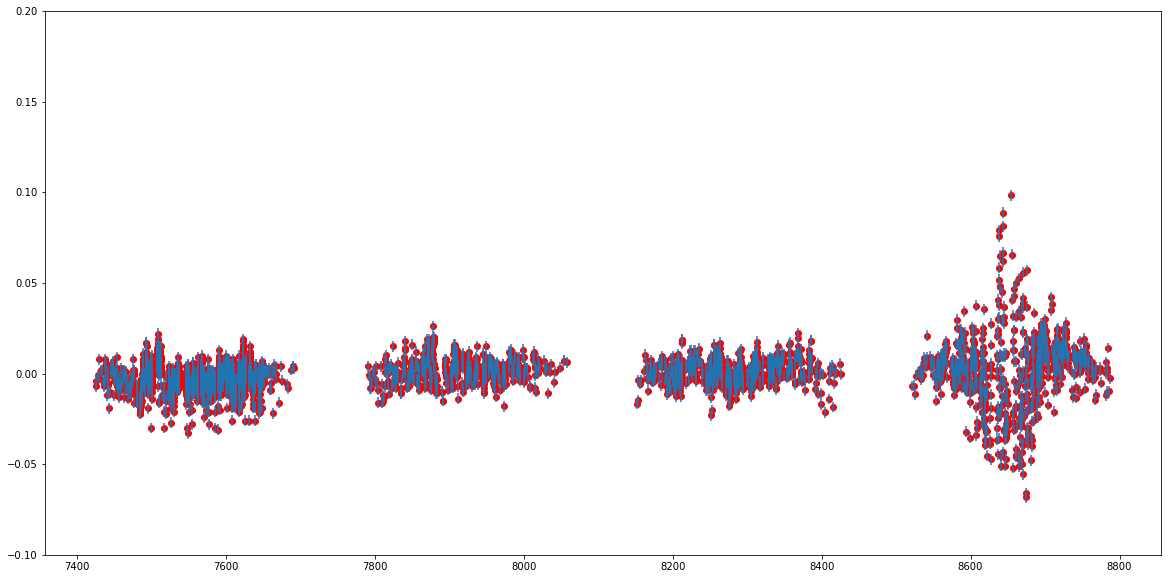

In [80]:

residual = (data3y- model([2.79412051e-01, 2.45865120e+06, 5.88102302e+01, 1.34040365e+01, 9.94931947e-01],data3))
fig,ax = plt.subplots(1,figsize=(20,10))
plt.scatter(data3x, residual, color = 'r')
plt.errorbar(data3x, residual, yerr = data3err, ls = 'none')
plt.ylim(-0.1, 0.2)